In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/My Drive/CZ_hsdb/img1.mat"

In [ ]:
from scipy.io import loadmat

data = loadmat(data_path)

# Print available keys (variables in the file)
print(data.keys())


dict_keys(['__header__', '__version__', '__globals__', 'ref', 'lbl'])


In [ ]:
'''
image_name = "image1.mat"  # Change to any loaded image
image_data = hyperspectral_data[image_name]

ref_data = image_data['ref']  # Hyperspectral data
lbl_data = image_data['lbl']  # Mask

print("Ref Shape:", ref_data.shape)
print("Lbl Shape:", lbl_data.shape)
'''

'\nimage_name = "image1.mat"  # Change to any loaded image\nimage_data = hyperspectral_data[image_name]\n\nref_data = image_data[\'ref\']  # Hyperspectral data\nlbl_data = image_data[\'lbl\']  # Mask\n\nprint("Ref Shape:", ref_data.shape)\nprint("Lbl Shape:", lbl_data.shape)\n'

# **CZ_HSI Applying PCA**

In [ ]:
"""
Hyperspectral Image Super-Resolution with Deep Residual Learning (40 Images) with PCA
--------------------------------------------------------------------------------------
Author: Kazi Asad
Dataset: CZ_hsdb (Real-world scenes; 31 channels: 420-720 nm)
Citation: Chakrabarti & Zickler, CVPR 2011

This script loads MATLAB files from the CZ_hsdb folder (each containing a hyperspectral
image 'ref' and a mask 'lbl'), resizes the data to 512x512 to preserve fine spatial detail
and reduce memory usage, applies PCA to reduce the spectral dimension, creates a lazy
dataset that randomly extracts patches on the fly (in PCA space), trains a residual
U-Net for HSI reconstruction, and evaluates the model (by inverting PCA) using PSNR,
SSIM, and SAM metrics. It also provides detailed visualizations of the data (post-resizing),
spatial and spectral results, error maps, and a training loss curve suitable for inclusion
in a research paper.
"""

# ===============================
# 1. Import Libraries
# ===============================
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from skimage.transform import resize
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from sklearn.decomposition import PCA



In [ ]:
# ===============================
# 2. Configuration
# ===============================
class Config:
    dataset_path = "/content/drive/My Drive/CZ_hsdb/"
    num_images = 40                # Use 30 images for training
    target_resolution = (512, 512) # Increase resolution to 512x512 for finer spatial detail
    patch_size = 32                # Spatial patch size for patches
    num_patches = 15000            # Total number of random patches per epoch
    batch_size = 8
    num_epochs = 10
    learning_rate = 1e-4
    weight_decay = 1e-4

    # PCA parameters
    pca_components = 3             # Number of spectral components after PCA reduction

    # For visualization: selected band indices and corresponding wavelengths (original space)
    bands_to_plot = [0, 10, 20, 30]  # Example indices (roughly corresponding to 420,520,620,720 nm)
    wavelengths = np.arange(420, 421 + 10*30, 10)  # 420,430,...,720 nm
    eval_sample_count = 100        # Number of patches to evaluate on
    checkpoint_path = "./hsi_model_checkpoint.pth"  # Path to save the best model


🔄 Loading and resizing MATLAB files from CZ_hsdb...
✅ img1.mat: original (1040, 1392, 31), resized (512, 512, 31)
✅ img2.mat: original (1040, 1392, 31), resized (512, 512, 31)
✅ imga1.mat: original (1040, 1392, 31), resized (512, 512, 31)
✅ imga2.mat: original (1040, 1392, 31), resized (512, 512, 31)
✅ imga5.mat: original (1040, 1392, 31), resized (512, 512, 31)
✅ imga6.mat: original (1040, 1392, 31), resized (512, 512, 31)
✅ imga7.mat: original (1040, 1392, 31), resized (512, 512, 31)
✅ imgb0.mat: original (1040, 1392, 31), resized (512, 512, 31)
✅ imgb1.mat: original (1040, 1392, 31), resized (512, 512, 31)
✅ imgb2.mat: original (1040, 1392, 31), resized (512, 512, 31)
✅ imgb3.mat: original (1040, 1392, 31), resized (512, 512, 31)
✅ imgb4.mat: original (1040, 1392, 31), resized (512, 512, 31)
✅ imgb5.mat: original (1040, 1392, 31), resized (512, 512, 31)
✅ imgb6.mat: original (1040, 1392, 31), resized (512, 512, 31)
✅ imgb7.mat: original (1040, 1392, 31), resized (512, 512, 31)
✅ img

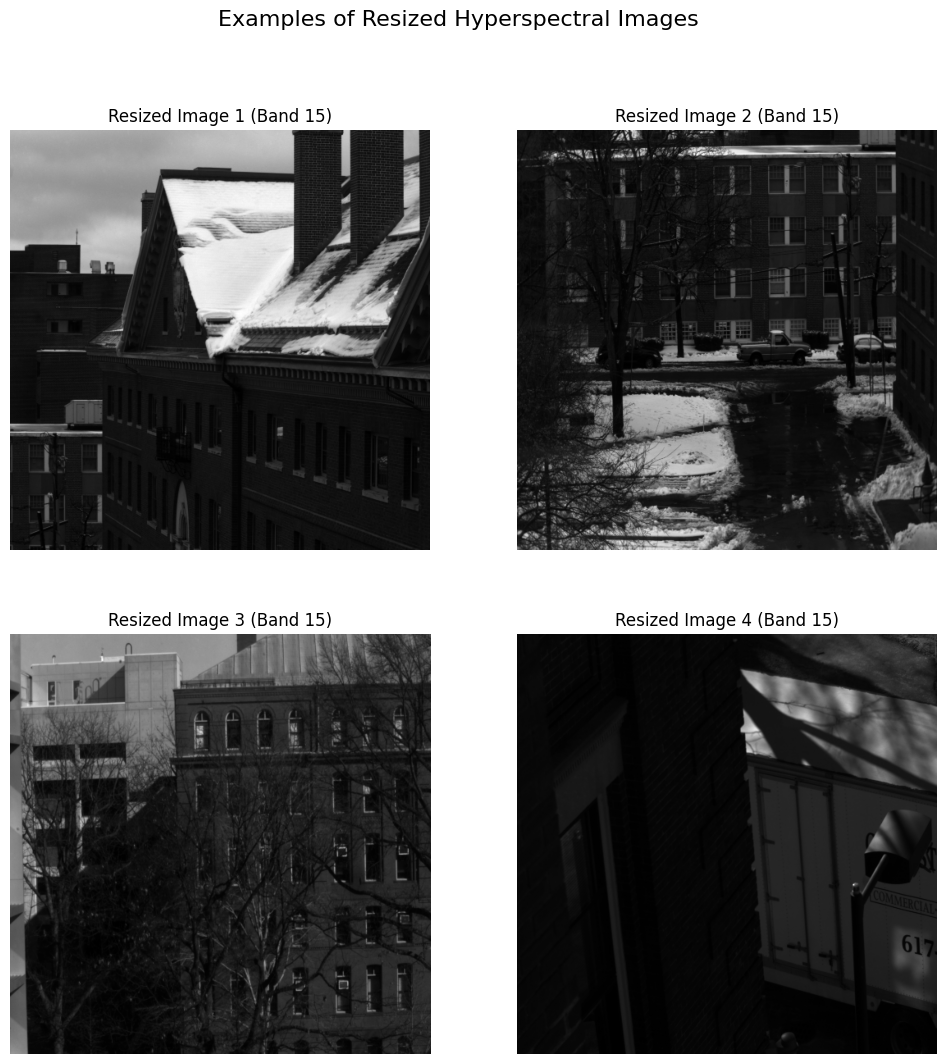

🔄 Fitting global PCA on the loaded hyperspectral images...
✅ PCA fitted with 3 components (explained variance ratio sum: 0.995)


In [ ]:

# ===============================
# 3. Load, Resize, and Apply PCA to .mat Files from CZ_hsdb
# ===============================
def load_and_resize_hs_images(dataset_path, target_shape=(512,512), num_images=30):
    """
    Loads and resizes hyperspectral images from MATLAB .mat files.

    Returns:
        List of resized hyperspectral images (numpy arrays with shape [H, W, 31]).
    """
    print("🔄 Loading and resizing MATLAB files from CZ_hsdb...")
    mat_files = sorted([f for f in os.listdir(dataset_path) if f.endswith('.mat')])[:num_images]

    hs_images = []
    for mat_file in mat_files:
        file_path = os.path.join(dataset_path, mat_file)
        data = loadmat(file_path)
        ref = data.get('ref', None)  # Expected shape: (H, W, 31)
        if ref is not None:
            ref = ref.astype(np.float32)
            # Normalize to [0,1]
            ref_min, ref_max = ref.min(), ref.max()
            norm_img = (ref - ref_min) / (ref_max - ref_min + 1e-8)
            # Resize using bilinear interpolation with anti-aliasing
            resized = resize(norm_img, (*target_shape, norm_img.shape[2]), order=1,
                             preserve_range=True, anti_aliasing=True).astype(np.float32)
            hs_images.append(resized)
            print(f"✅ {mat_file}: original {ref.shape}, resized {resized.shape}")
        else:
            print(f"⚠️ Skipped {mat_file}: 'ref' key missing.")
    print(f"\n📦 Total images loaded and resized: {len(hs_images)}\n")
    return hs_images

# First, load and resize the hyperspectral images.
hs_images = load_and_resize_hs_images(Config.dataset_path, target_shape=Config.target_resolution, num_images=Config.num_images)

# Optional: Display a few resized images (using a representative band for inspection)
num_display = min(4, len(hs_images))
plt.figure(figsize=(12, 12))
for idx in range(num_display):
    plt.subplot(2, 2, idx+1)
    plt.imshow(hs_images[idx][..., 15], cmap='gray')
    plt.title(f"Resized Image {idx+1} (Band 15)")
    plt.axis('off')
plt.suptitle("Examples of Resized Hyperspectral Images", fontsize=16)
plt.show()

# -------------------------------
# 3a. Apply Global PCA to Reduce Spectral Dimension
# -------------------------------
def apply_global_pca(hs_images, n_components):
    """
    Applies a global PCA transformation based on all the images.

    Parameters:
        hs_images: List of images, each of shape (H, W, C) where C is the number of spectral channels.
        n_components: Desired PCA components.

    Returns:
        pca_images: List of images in PCA space with shape (H, W, n_components).
        pca: the trained PCA model (with inverse_transform method).
    """
    print("🔄 Fitting global PCA on the loaded hyperspectral images...")
    # Stack all pixels from all images together
    all_pixels = np.concatenate([img.reshape(-1, img.shape[2]) for img in hs_images], axis=0)
    pca = PCA(n_components=n_components)
    pca.fit(all_pixels)
    print(f"✅ PCA fitted with {n_components} components (explained variance ratio sum: {pca.explained_variance_ratio_.sum():.3f})")

    # Transform each image and reshape back to (H,W,n_components)
    pca_images = [pca.transform(img.reshape(-1, img.shape[2])).reshape(img.shape[0], img.shape[1], n_components)
                  for img in hs_images]
    return pca_images, pca

pca_images, pca_model = apply_global_pca(hs_images, Config.pca_components)


In [ ]:
# ===============================
# 4. Define a Lazy Dataset for Efficient Patch Extraction (in PCA space)
# ===============================
class LazyHSIDataset(Dataset):
    def __init__(self, pca_images, patch_size=32, num_patches=15000):
        """
        pca_images: list of PCA-transformed hyperspectral images, each with shape (H, W, pca_components)
        patch_size: spatial patch size (assumed square)
        num_patches: total number of random patches per epoch
        """
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.pad = patch_size // 2
        self.images = []
        self.image_shapes = []
        for img in pca_images:
            padded = np.pad(img, ((self.pad, self.pad), (self.pad, self.pad), (0, 0)), mode='reflect')
            self.images.append(padded)
            H, W, _ = img.shape
            self.image_shapes.append((H, W))
        self.num_images = len(self.images)

    def __len__(self):
        return self.num_patches

    def __getitem__(self, idx):
        img_idx = np.random.randint(0, self.num_images)
        img = self.images[img_idx]
        H, W = self.image_shapes[img_idx]
        row = np.random.randint(self.pad, self.pad + H)
        col = np.random.randint(self.pad, self.pad + W)
        patch = img[row - self.pad: row + self.pad, col - self.pad: col + self.pad, :].copy()
        patch_tensor = torch.tensor(patch, dtype=torch.float32).permute(2, 0, 1)  # (channels, H, W)
        return patch_tensor

# Create dataset and dataloader using PCA-transformed images
dataset = LazyHSIDataset(pca_images, patch_size=Config.patch_size, num_patches=Config.num_patches)
dataloader = DataLoader(dataset, batch_size=Config.batch_size, shuffle=True, num_workers=0)



In [ ]:
# ===============================
# 5. Model Architecture: Residual U-Net for HSI Reconstruction in PCA Space
# ===============================
class ResidualBlock(nn.Module):
    """Residual block with spectral normalization."""
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(channels, channels, 3, padding=1)),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Conv2d(channels, channels, 3, padding=1))
        )
    def forward(self, x):
        return x + self.conv(x)

class HSIResUNet(nn.Module):
    """
    Residual U-Net for HSI reconstruction in PCA space.
    Input and output channels equal the PCA components.
    """
    def __init__(self):
        super().__init__()
        in_channels = Config.pca_components
        self.enc1 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(in_channels, 64, 3, padding=1)),
            ResidualBlock(64),
            nn.LeakyReLU(0.2)
        )
        self.enc2 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.utils.spectral_norm(nn.Conv2d(64, 128, 3, padding=1)),
            ResidualBlock(128),
            nn.LeakyReLU(0.2)
        )
        self.dec1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.utils.spectral_norm(nn.Conv2d(128, 64, 3, padding=1)),
            ResidualBlock(64),
            nn.LeakyReLU(0.2)
        )
        self.final = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(64, 32, 3, padding=1)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, in_channels, 1)
        )
    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.dec1(x2)
        return self.final(x3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HSIResUNet().to(device)
optimizer = optim.AdamW(model.parameters(), lr=Config.learning_rate, weight_decay=Config.weight_decay)

In [ ]:
# ===============================
# 6. Define Evaluation Metrics Functions (with PCA inversion)
# ===============================
def spectral_angle_mapper(original, reconstructed):
    """Calculate the spectral angle (SAM) in radians."""
    orig_flat = original.reshape(-1, original.shape[-1])
    recon_flat = reconstructed.reshape(-1, original.shape[-1])
    dot = np.sum(orig_flat * recon_flat, axis=1)
    norm_orig = np.linalg.norm(orig_flat, axis=1)
    norm_recon = np.linalg.norm(recon_flat, axis=1)
    valid = (norm_orig > 1e-6) & (norm_recon > 1e-6)
    cos_sim = np.clip(dot[valid] / (norm_orig[valid] * norm_recon[valid]), -1, 1)
    return np.mean(np.arccos(cos_sim))

def calculate_metrics(original, reconstructed):
    """
    original, reconstructed: arrays of shape (H, W, 31) in the original full spectrum.
    Returns average PSNR (dB), SSIM, and SAM (radians) over all channels.
    """
    psnr_total = 0.0
    ssim_total = 0.0
    C = original.shape[-1]
    for b in range(C):
        psnr_total += peak_signal_noise_ratio(original[..., b], reconstructed[..., b], data_range=1.0)
        ssim_total += structural_similarity(original[..., b], reconstructed[..., b], data_range=1.0)
    psnr_avg = psnr_total / C
    ssim_avg = ssim_total / C
    sam_val = spectral_angle_mapper(original, reconstructed)
    return psnr_avg, ssim_avg, sam_val



In [ ]:
# ===============================
# 7. Training Loop with Loss Logging, Evaluation Metrics & Checkpointing
# ===============================
print("\n🚀 Starting Training...")
train_losses = []
epoch_psnr = []  # Average PSNR per epoch
epoch_ssim = []  # Average SSIM per epoch
epoch_sam  = []  # Average SAM per epoch

best_psnr = -np.inf  # For checkpointing based on evaluation PSNR

for epoch in range(Config.num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{Config.num_epochs}"):
        batch = batch.to(device)  # (batch, pca_components, patch_size, patch_size)
        outputs = model(batch)
        loss = F.l1_loss(outputs, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(dataloader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}: Average L1 Loss = {avg_loss:.4f}")

    # Evaluate on random patches at the end of the epoch
    model.eval()
    psnr_list = []
    ssim_list = []
    sam_list = []
    for _ in range(Config.eval_sample_count):
        patch = dataset[np.random.randint(0, len(dataset))]
        patch_tensor = patch.unsqueeze(0).to(device)
        with torch.no_grad():
            recon_pca = model(patch_tensor).cpu().squeeze().permute(1, 2, 0).numpy()
        # Invert PCA to recover the full 31-channel spectrum for evaluation.
        # First, get the original patch in PCA space:
        orig_pca = patch.cpu().permute(1, 2, 0).numpy()
        # Reshape patch for inverse transform
        H, W, _ = orig_pca.shape
        orig_full = pca_model.inverse_transform(orig_pca.reshape(-1, Config.pca_components)).reshape(H, W, -1)
        recon_full = pca_model.inverse_transform(recon_pca.reshape(-1, Config.pca_components)).reshape(H, W, -1)
        psnr_val, ssim_val, sam_val = calculate_metrics(orig_full, recon_full)
        psnr_list.append(psnr_val)
        ssim_list.append(ssim_val)
        sam_list.append(sam_val)
    avg_epoch_psnr = np.mean(psnr_list)
    avg_epoch_ssim = np.mean(ssim_list)
    avg_epoch_sam  = np.mean(sam_list)
    epoch_psnr.append(avg_epoch_psnr)
    epoch_ssim.append(avg_epoch_ssim)
    epoch_sam.append(avg_epoch_sam)

    print(f"Epoch {epoch+1}: Eval PSNR = {avg_epoch_psnr:.2f} dB, SSIM = {avg_epoch_ssim:.4f}, SAM = {avg_epoch_sam:.4f} rad")

    # Save checkpoint if evaluation PSNR improves
    if avg_epoch_psnr > best_psnr or best_psnr < 0:
        best_psnr = avg_epoch_psnr
        torch.save(model.state_dict(), Config.checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch+1}")




🚀 Starting Training...


Epoch 1/10: 100%|██████████| 1875/1875 [00:21<00:00, 87.76it/s]


Epoch 1: Average L1 Loss = 0.0356
Epoch 1: Eval PSNR = 41.44 dB, SSIM = 0.9556, SAM = 0.0344 rad
Checkpoint saved at epoch 1


Epoch 2/10: 100%|██████████| 1875/1875 [00:19<00:00, 98.20it/s] 


Epoch 2: Average L1 Loss = 0.0226
Epoch 2: Eval PSNR = 45.18 dB, SSIM = 0.9733, SAM = 0.0254 rad
Checkpoint saved at epoch 2


Epoch 3/10: 100%|██████████| 1875/1875 [00:19<00:00, 95.36it/s] 


Epoch 3: Average L1 Loss = 0.0198
Epoch 3: Eval PSNR = 46.20 dB, SSIM = 0.9792, SAM = 0.0221 rad
Checkpoint saved at epoch 3


Epoch 4/10: 100%|██████████| 1875/1875 [00:18<00:00, 99.21it/s] 


Epoch 4: Average L1 Loss = 0.0180
Epoch 4: Eval PSNR = 45.01 dB, SSIM = 0.9746, SAM = 0.0247 rad


Epoch 5/10: 100%|██████████| 1875/1875 [00:19<00:00, 94.85it/s] 


Epoch 5: Average L1 Loss = 0.0164
Epoch 5: Eval PSNR = 46.37 dB, SSIM = 0.9806, SAM = 0.0223 rad
Checkpoint saved at epoch 5


Epoch 6/10: 100%|██████████| 1875/1875 [00:19<00:00, 98.64it/s] 


Epoch 6: Average L1 Loss = 0.0152
Epoch 6: Eval PSNR = 46.72 dB, SSIM = 0.9830, SAM = 0.0195 rad
Checkpoint saved at epoch 6


Epoch 7/10: 100%|██████████| 1875/1875 [00:19<00:00, 97.39it/s] 


Epoch 7: Average L1 Loss = 0.0142
Epoch 7: Eval PSNR = 47.46 dB, SSIM = 0.9850, SAM = 0.0164 rad
Checkpoint saved at epoch 7


Epoch 8/10: 100%|██████████| 1875/1875 [00:22<00:00, 82.50it/s]


Epoch 8: Average L1 Loss = 0.0132
Epoch 8: Eval PSNR = 47.97 dB, SSIM = 0.9867, SAM = 0.0174 rad
Checkpoint saved at epoch 8


Epoch 9/10: 100%|██████████| 1875/1875 [00:19<00:00, 96.37it/s]


Epoch 9: Average L1 Loss = 0.0130
Epoch 9: Eval PSNR = 46.73 dB, SSIM = 0.9861, SAM = 0.0175 rad


Epoch 10/10: 100%|██████████| 1875/1875 [00:21<00:00, 88.25it/s]


Epoch 10: Average L1 Loss = 0.0124
Epoch 10: Eval PSNR = 50.38 dB, SSIM = 0.9907, SAM = 0.0160 rad
Checkpoint saved at epoch 10


In [ ]:
# ===============================
# 8. Final Evaluation on Random Patches
# ===============================
print("\n🔍 Final Evaluation on random patches...")
model.eval()
psnr_list = []
ssim_list = []
sam_list = []
for _ in range(Config.eval_sample_count):
    patch = dataset[np.random.randint(0, len(dataset))]
    patch_tensor = patch.unsqueeze(0).to(device)
    with torch.no_grad():
        recon_pca = model(patch_tensor).cpu().squeeze().permute(1, 2, 0).numpy()
    orig_pca = patch.cpu().permute(1, 2, 0).numpy()
    H, W, _ = orig_pca.shape
    orig_full = pca_model.inverse_transform(orig_pca.reshape(-1, Config.pca_components)).reshape(H, W, -1)
    recon_full = pca_model.inverse_transform(recon_pca.reshape(-1, Config.pca_components)).reshape(H, W, -1)
    psnr_val, ssim_val, sam_val = calculate_metrics(orig_full, recon_full)
    psnr_list.append(psnr_val)
    ssim_list.append(ssim_val)
    sam_list.append(sam_val)

avg_psnr = np.mean(psnr_list)
avg_ssim = np.mean(ssim_list)
avg_sam = np.mean(sam_list)
print(f"\nFinal Evaluation Metrics (averaged over {Config.eval_sample_count} patches):")
print(f"PSNR: {avg_psnr:.2f} dB")
print(f"SSIM: {avg_ssim:.4f}")
print(f"SAM: {avg_sam:.4f} radians")



🔍 Final Evaluation on random patches...

Final Evaluation Metrics (averaged over 100 patches):
PSNR: 49.25 dB
SSIM: 0.9892
SAM: 0.0190 radians


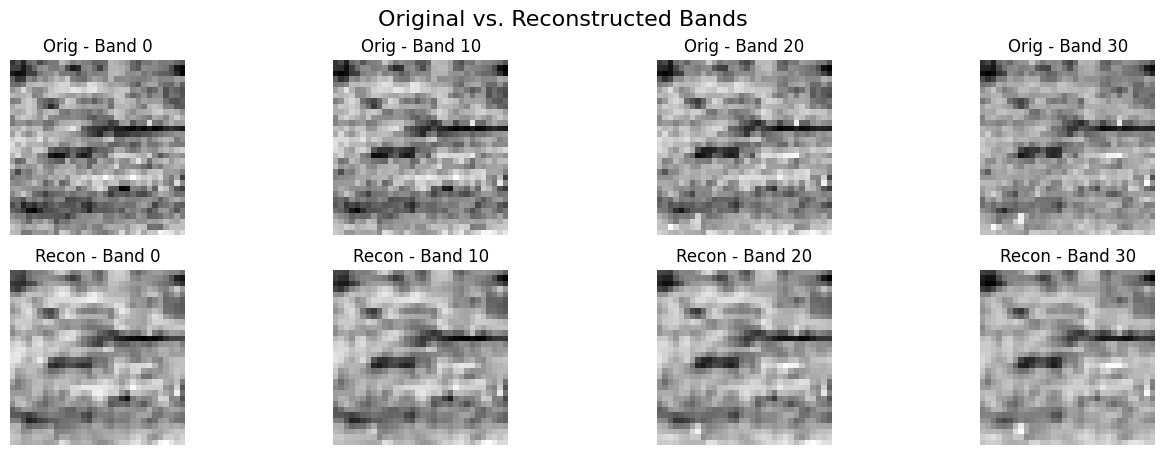

In [ ]:
# ===============================
# 9. Enhanced Visualization for Research Paper (with PCA inversion)
# ===============================
model.eval()
with torch.no_grad():
    sample_idx = np.random.randint(0, len(dataset))
    sample = dataset[sample_idx].unsqueeze(0).to(device)
    output_pca = model(sample).cpu().squeeze().permute(1, 2, 0).numpy()  # (patch_size, patch_size, pca_components)
    sample_pca = sample.cpu().squeeze().permute(1, 2, 0).numpy()
    # Invert PCA to get full 31-channel reconstruction
    patch_size = Config.patch_size
    output_full = pca_model.inverse_transform(output_pca.reshape(-1, Config.pca_components)).reshape(patch_size, patch_size, -1)
    sample_full = pca_model.inverse_transform(sample_pca.reshape(-1, Config.pca_components)).reshape(patch_size, patch_size, -1)

# -------- Display Multiple Bands --------
num_display_bands = len(Config.bands_to_plot)
plt.figure(figsize=(4 * num_display_bands, 5))
for i, band in enumerate(Config.bands_to_plot):
    plt.subplot(2, num_display_bands, i + 1)
    plt.imshow(sample_full[..., band], cmap='gray')
    plt.title(f"Orig - Band {band}")
    plt.axis('off')

    plt.subplot(2, num_display_bands, num_display_bands + i + 1)
    plt.imshow(output_full[..., band], cmap='gray')
    plt.title(f"Recon - Band {band}")
    plt.axis('off')
plt.suptitle("Original vs. Reconstructed Bands", fontsize=16)
plt.show()



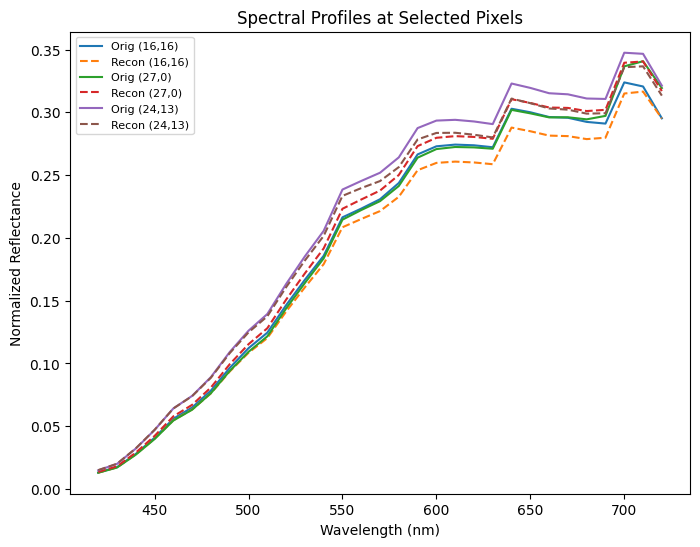

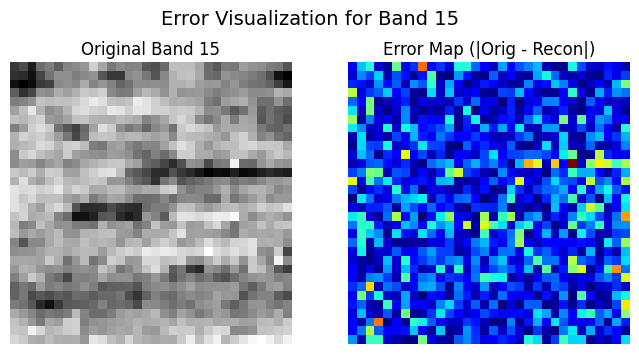

In [ ]:
# -------- Plot Spectral Profiles at Multiple Points --------
points = [(Config.patch_size // 2, Config.patch_size // 2)]
for _ in range(2):
    i = np.random.randint(0, Config.patch_size)
    j = np.random.randint(0, Config.patch_size)
    points.append((i, j))

plt.figure(figsize=(8,6))
for (i, j) in points:
    plt.plot(Config.wavelengths, sample_full[i, j], label=f"Orig ({i},{j})", linestyle='-')
    plt.plot(Config.wavelengths, output_full[i, j], label=f"Recon ({i},{j})", linestyle='--')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalized Reflectance")
plt.title("Spectral Profiles at Selected Pixels")
plt.legend(loc='best', fontsize=8)
plt.show()

# -------- Display Error Map for One Representative Band --------
band_choice = 15  # Example: use band 15 from the full spectrum
error_map = np.abs(sample_full[..., band_choice] - output_full[..., band_choice])
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(sample_full[..., band_choice], cmap='gray')
plt.title(f"Original Band {band_choice}")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(error_map, cmap='jet')
plt.title("Error Map (|Orig - Recon|)")
plt.axis('off')
plt.suptitle(f"Error Visualization for Band {band_choice}", fontsize=14)
plt.show()

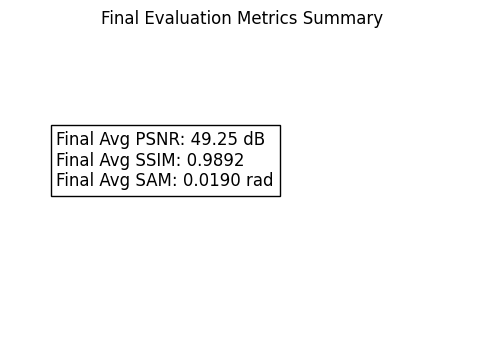

In [ ]:
# -------- Aggregate Metrics Visualization --------
plt.figure(figsize=(6,4))
text_str = f"Final Avg PSNR: {avg_psnr:.2f} dB\nFinal Avg SSIM: {avg_ssim:.4f}\nFinal Avg SAM: {avg_sam:.4f} rad"
plt.text(0.1, 0.5, text_str, fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))
plt.axis('off')
plt.title("Final Evaluation Metrics Summary")
plt.show()

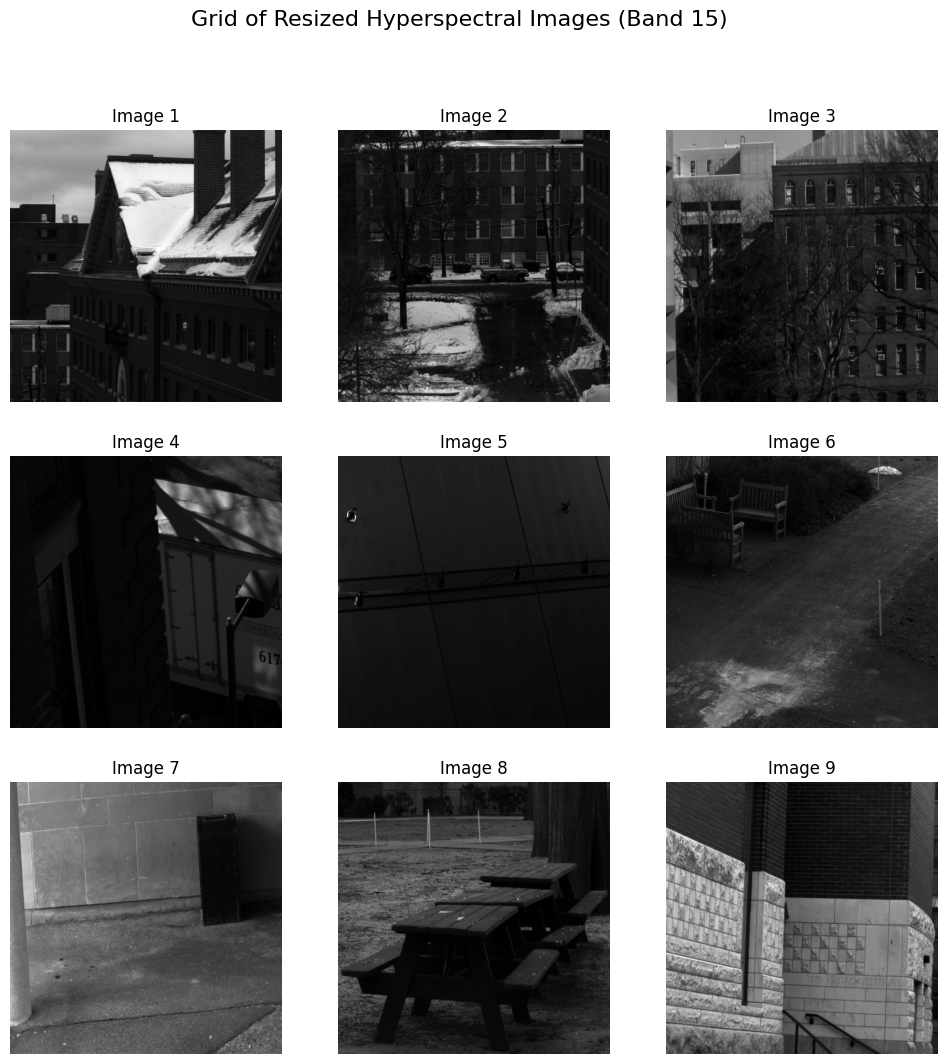

In [ ]:
# -------- Display a Grid of Some Resized Images (Original, for reference) --------
num_images_to_show = min(9, len(hs_images))
plt.figure(figsize=(12, 12))
for idx in range(num_images_to_show):
    plt.subplot(3, 3, idx+1)
    plt.imshow(hs_images[idx][..., 15], cmap='gray')
    plt.title(f"Image {idx+1}")
    plt.axis('off')
plt.suptitle("Grid of Resized Hyperspectral Images (Band 15)", fontsize=16)
plt.show()

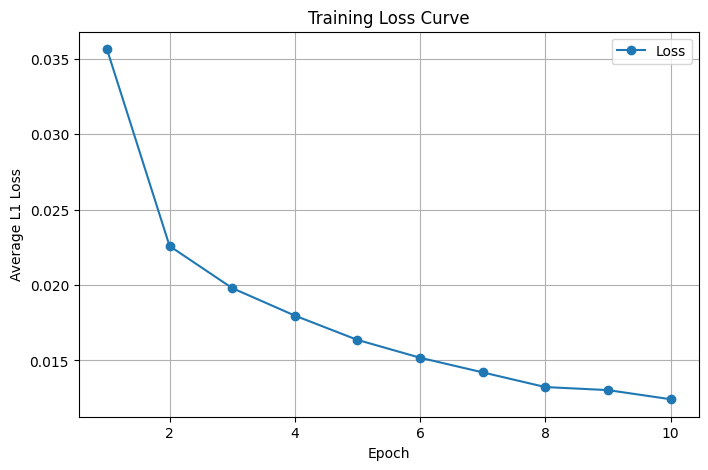

In [ ]:

# -------- Plot Training Loss Curve --------
plt.figure(figsize=(8,5))
plt.plot(range(1, Config.num_epochs+1), train_losses, marker='o', label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Average L1 Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.legend()
plt.show()

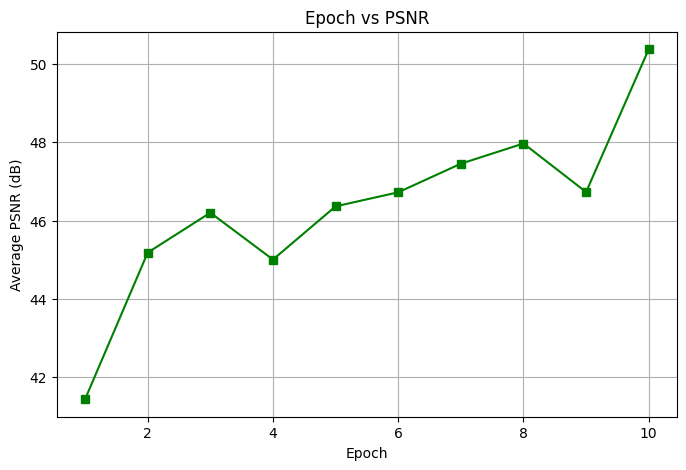

In [ ]:
# -------- Plot Epoch vs PSNR --------
plt.figure(figsize=(8,5))
plt.plot(range(1, Config.num_epochs+1), epoch_psnr, marker='s', color='green')
plt.xlabel("Epoch")
plt.ylabel("Average PSNR (dB)")
plt.title("Epoch vs PSNR")
plt.grid(True)
plt.show()


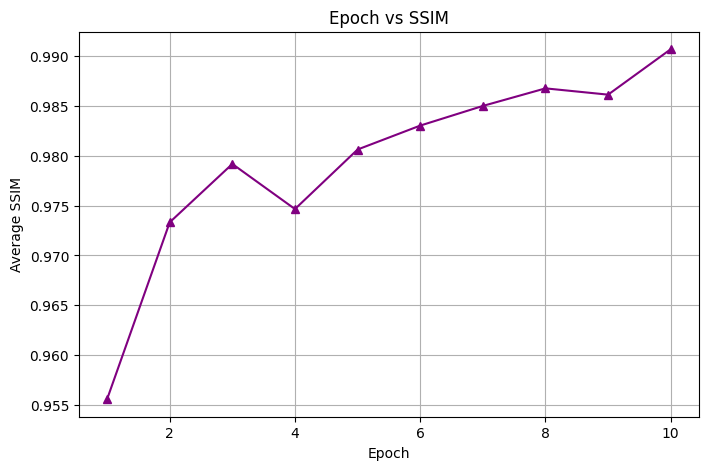

In [ ]:
# -------- Plot Epoch vs SSIM --------
plt.figure(figsize=(8,5))
plt.plot(range(1, Config.num_epochs+1), epoch_ssim, marker='^', color='purple')
plt.xlabel("Epoch")
plt.ylabel("Average SSIM")
plt.title("Epoch vs SSIM")
plt.grid(True)
plt.show()

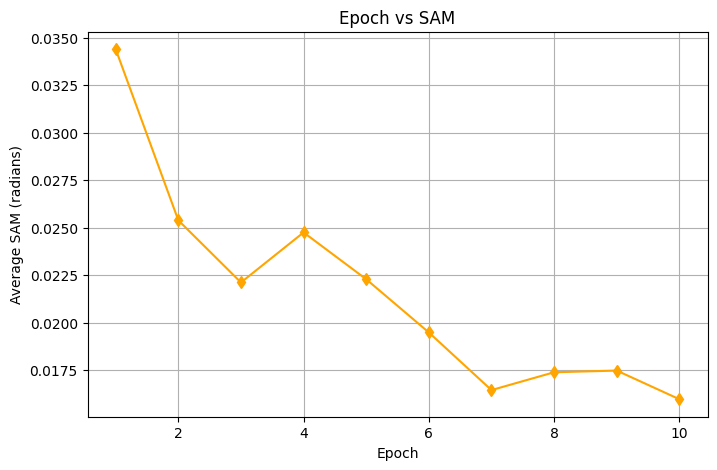

In [ ]:
# -------- Plot Epoch vs SAM --------
plt.figure(figsize=(8,5))
plt.plot(range(1, Config.num_epochs+1), epoch_sam, marker='d', color='orange')
plt.xlabel("Epoch")
plt.ylabel("Average SAM (radians)")
plt.title("Epoch vs SAM")
plt.grid(True)
plt.show()

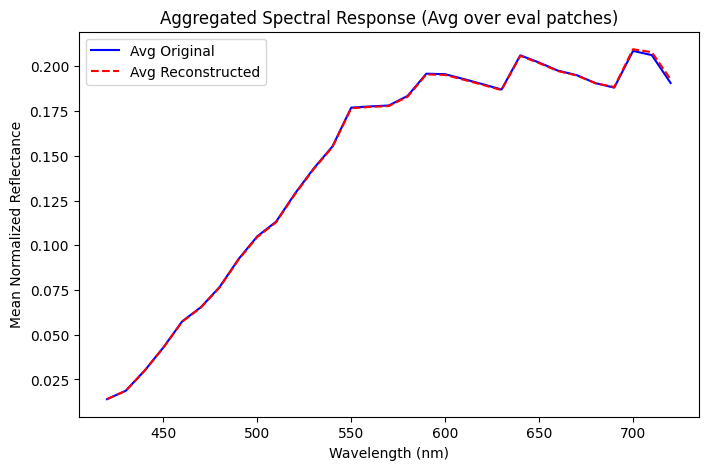

In [ ]:
# -------- Compute and Plot an Aggregated Spectral Response --------
all_orig_spectra = []
all_recon_spectra = []
for _ in range(Config.eval_sample_count):
    patch = dataset[np.random.randint(0, len(dataset))]
    patch_tensor = patch.unsqueeze(0).to(device)
    with torch.no_grad():
        recon_pca = model(patch_tensor).cpu().squeeze().permute(1, 2, 0).numpy()
    orig_pca = patch.cpu().permute(1, 2, 0).numpy()
    H, W, _ = orig_pca.shape
    orig_full = pca_model.inverse_transform(orig_pca.reshape(-1, Config.pca_components)).reshape(H, W, -1)
    recon_full = pca_model.inverse_transform(recon_pca.reshape(-1, Config.pca_components)).reshape(H, W, -1)
    all_orig_spectra.append(orig_full.mean(axis=(0,1)))
    all_recon_spectra.append(recon_full.mean(axis=(0,1)))
avg_orig_spectrum = np.mean(all_orig_spectra, axis=0)
avg_recon_spectrum = np.mean(all_recon_spectra, axis=0)

plt.figure(figsize=(8,5))
plt.plot(Config.wavelengths, avg_orig_spectrum, 'b-', label='Avg Original')
plt.plot(Config.wavelengths, avg_recon_spectrum, 'r--', label='Avg Reconstructed')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Mean Normalized Reflectance")
plt.title("Aggregated Spectral Response (Avg over eval patches)")
plt.legend(loc='best')
plt.show()

# **CZ_HSI without PCA**





In [ ]:
"""
Hyperspectral Image Super-Resolution with Deep Residual Learning (30 Images)
----------------------------------------------------------------------------
Author: Kazi Asad
Dataset: CZ_hsdb (Real-world scenes; 31 channels: 420-720 nm)
Citation: Chakrabarti & Zickler, CVPR 2011

This script loads MATLAB files from the CZ_hsdb folder (each containing a hyperspectral
image 'ref' and a mask 'lbl'), resizes the data to 512x512 to preserve fine spatial detail
and reduce memory usage, creates a lazy dataset that randomly extracts patches on the fly,
trains a residual U-Net for HSI reconstruction, and evaluates the model using PSNR, SSIM,
and SAM metrics. It also provides detailed visualizations of the data (post-resizing),
spatial and spectral results, error maps, and a training loss curve suitable for inclusion
in a research paper.
"""

# ===============================
# 1. Import Libraries
# ===============================
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from tqdm import tqdm
from skimage.transform import resize

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from skimage.metrics import peak_signal_noise_ratio, structural_similarity


In [ ]:
# ===============================
# 2. Configuration
# ===============================
class Config:
    dataset_path = "/content/drive/My Drive/CZ_hsdb/"
    num_images = 40                # Use 30 images for training
    target_resolution = (512, 512) # Increase resolution to 512x512 for finer spatial detail
    patch_size = 32                # Spatial patch size for patches
    num_patches = 15000            # Total number of random patches per epoch
    batch_size = 8
    num_epochs = 10
    learning_rate = 1e-4
    weight_decay = 1e-4
    # For visualization: selected band indices and corresponding wavelengths
    bands_to_plot = [0, 10, 20, 30]  # Indices roughly corresponding to 420,520,620,720 nm
    wavelengths = np.arange(420, 421 + 10*30, 10)  # 420,430,...,720 nm
    eval_sample_count = 100        # Number of patches to evaluate on
    checkpoint_path = "./hsi_model_checkpoint.pth"  # Path to save the best model

In [ ]:
# ===============================
# 3. Load and Resize .mat Files from CZ_hsdb
# ===============================
def load_and_resize_hs_images(dataset_path, target_shape=(512,512), num_images=30):
    """
    Loads and resizes hyperspectral images from MATLAB .mat files.

    Parameters:
        dataset_path (str): Directory containing the .mat files.
        target_shape (tuple): Spatial resolution (H, W) to resize to.
        num_images (int): Maximum number of images to load.

    Returns:
        List of resized hyperspectral images (numpy arrays with shape [H, W, 31]).
    """
    print("🔄 Loading and resizing MATLAB files from CZ_hsdb...")
    mat_files = sorted([f for f in os.listdir(dataset_path) if f.endswith('.mat')])[:num_images]

    hs_images = []
    for mat_file in mat_files:
        file_path = os.path.join(dataset_path, mat_file)
        data = loadmat(file_path)
        ref = data.get('ref', None)  # Expected shape: (H, W, 31)
        if ref is not None:
            ref = ref.astype(np.float32)
            # Normalize to [0,1]
            ref_min, ref_max = ref.min(), ref.max()
            norm_img = (ref - ref_min) / (ref_max - ref_min + 1e-8)
            # Resize using bilinear interpolation with anti-aliasing
            resized = resize(norm_img, (*target_shape, norm_img.shape[2]), order=1,
                             preserve_range=True, anti_aliasing=True).astype(np.float32)
            hs_images.append(resized)
            print(f"✅ {mat_file}: original {ref.shape}, resized {resized.shape}")
        else:
            print(f"⚠️ Skipped {mat_file}: 'ref' key missing.")
    print(f"\n📦 Total images loaded and resized: {len(hs_images)}\n")
    return hs_images

🔄 Loading and resizing MATLAB files from CZ_hsdb...
✅ img1.mat: original (1040, 1392, 31), resized (512, 512, 31)
✅ img2.mat: original (1040, 1392, 31), resized (512, 512, 31)
✅ imga1.mat: original (1040, 1392, 31), resized (512, 512, 31)
✅ imga2.mat: original (1040, 1392, 31), resized (512, 512, 31)
✅ imga5.mat: original (1040, 1392, 31), resized (512, 512, 31)
✅ imga6.mat: original (1040, 1392, 31), resized (512, 512, 31)
✅ imga7.mat: original (1040, 1392, 31), resized (512, 512, 31)
✅ imgb0.mat: original (1040, 1392, 31), resized (512, 512, 31)
✅ imgb1.mat: original (1040, 1392, 31), resized (512, 512, 31)
✅ imgb2.mat: original (1040, 1392, 31), resized (512, 512, 31)
✅ imgb3.mat: original (1040, 1392, 31), resized (512, 512, 31)
✅ imgb4.mat: original (1040, 1392, 31), resized (512, 512, 31)
✅ imgb5.mat: original (1040, 1392, 31), resized (512, 512, 31)
✅ imgb6.mat: original (1040, 1392, 31), resized (512, 512, 31)
✅ imgb7.mat: original (1040, 1392, 31), resized (512, 512, 31)
✅ img

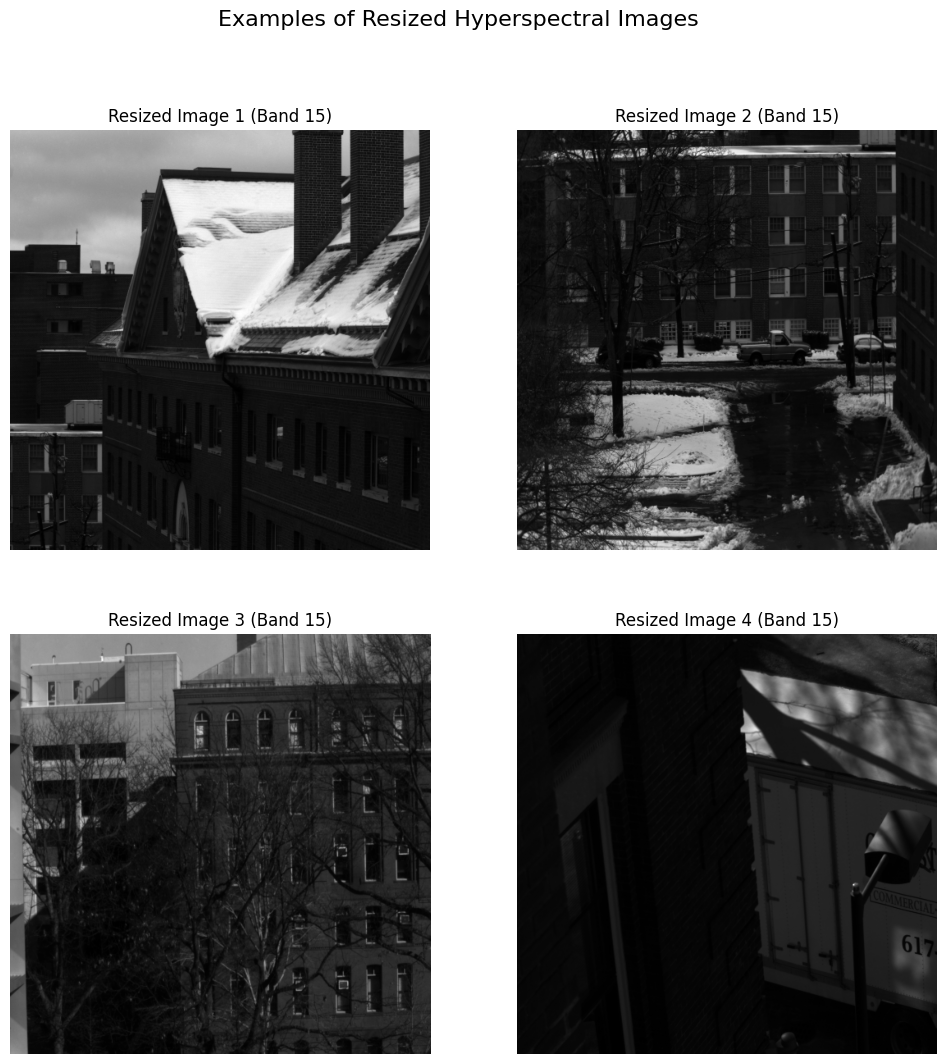

In [ ]:
# Load and inspect data
hs_images = load_and_resize_hs_images(Config.dataset_path, target_shape=Config.target_resolution, num_images=Config.num_images)

# -------- Display a few resized images (representative band) for inspection --------
num_display = min(4, len(hs_images))
plt.figure(figsize=(12, 12))
for idx in range(num_display):
    plt.subplot(2, 2, idx+1)
    plt.imshow(hs_images[idx][..., 15], cmap='gray')
    plt.title(f"Resized Image {idx+1} (Band 15)")
    plt.axis('off')
plt.suptitle("Examples of Resized Hyperspectral Images", fontsize=16)
plt.show()

In [ ]:
# ===============================
# 4. Define a Lazy Dataset for Efficient Patch Extraction
# ===============================
class LazyHSIDataset(Dataset):
    def __init__(self, hs_images, patch_size=32, num_patches=15000):
        """
        hs_images: list of hyperspectral images, each with shape (H, W, 31)
        patch_size: spatial patch size (assumed square)
        num_patches: total number of random patches per epoch
        """
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.pad = patch_size // 2
        self.images = []
        self.image_shapes = []
        for img in hs_images:
            padded = np.pad(img, ((self.pad, self.pad), (self.pad, self.pad), (0, 0)), mode='reflect')
            self.images.append(padded)
            H, W, _ = img.shape
            self.image_shapes.append((H, W))
        self.num_images = len(self.images)

    def __len__(self):
        return self.num_patches

    def __getitem__(self, idx):
        img_idx = np.random.randint(0, self.num_images)
        img = self.images[img_idx]
        H, W = self.image_shapes[img_idx]
        row = np.random.randint(self.pad, self.pad + H)
        col = np.random.randint(self.pad, self.pad + W)
        patch = img[row - self.pad: row + self.pad, col - self.pad: col + self.pad, :].copy()
        patch_tensor = torch.tensor(patch, dtype=torch.float32).permute(2, 0, 1)
        return patch_tensor

# Create dataset and dataloader
dataset = LazyHSIDataset(hs_images, patch_size=Config.patch_size, num_patches=Config.num_patches)
dataloader = DataLoader(dataset, batch_size=Config.batch_size, shuffle=True, num_workers=0)


In [ ]:
# ===============================
# 5. Model Architecture: Residual U-Net for HSI Reconstruction
# ===============================
class ResidualBlock(nn.Module):
    """Residual block with spectral normalization."""
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(channels, channels, 3, padding=1)),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Conv2d(channels, channels, 3, padding=1))
        )
    def forward(self, x):
        return x + self.conv(x)

class HSIResUNet(nn.Module):
    """Residual U-Net for HSI reconstruction (input/output channels = 31)."""
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(31, 64, 3, padding=1)),
            ResidualBlock(64),
            nn.LeakyReLU(0.2)
        )
        self.enc2 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.utils.spectral_norm(nn.Conv2d(64, 128, 3, padding=1)),
            ResidualBlock(128),
            nn.LeakyReLU(0.2)
        )
        self.dec1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.utils.spectral_norm(nn.Conv2d(128, 64, 3, padding=1)),
            ResidualBlock(64),
            nn.LeakyReLU(0.2)
        )
        self.final = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(64, 32, 3, padding=1)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 31, 1)
        )
    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.dec1(x2)
        return self.final(x3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HSIResUNet().to(device)
optimizer = optim.AdamW(model.parameters(), lr=Config.learning_rate, weight_decay=Config.weight_decay)

In [ ]:
# ===============================
# 6. Define Evaluation Metrics Functions
# ===============================
def spectral_angle_mapper(original, reconstructed):
    """Calculate the spectral angle (SAM) in radians."""
    orig_flat = original.reshape(-1, original.shape[-1])
    recon_flat = reconstructed.reshape(-1, reconstructed.shape[-1])
    dot = np.sum(orig_flat * recon_flat, axis=1)
    norm_orig = np.linalg.norm(orig_flat, axis=1)
    norm_recon = np.linalg.norm(recon_flat, axis=1)
    valid = (norm_orig > 1e-6) & (norm_recon > 1e-6)
    cos_sim = np.clip(dot[valid] / (norm_orig[valid] * norm_recon[valid]), -1, 1)
    return np.mean(np.arccos(cos_sim))

def calculate_metrics(original, reconstructed):
    """
    original, reconstructed: arrays of shape (H, W, 31)
    Returns average PSNR (dB), SSIM, and SAM (radians) over all channels.
    """
    psnr_total = 0.0
    ssim_total = 0.0
    C = original.shape[-1]
    for b in range(C):
        psnr_total += peak_signal_noise_ratio(original[..., b], reconstructed[..., b], data_range=1.0)
        ssim_total += structural_similarity(original[..., b], reconstructed[..., b], data_range=1.0)
    psnr_avg = psnr_total / C
    ssim_avg = ssim_total / C
    sam_val = spectral_angle_mapper(original, reconstructed)
    return psnr_avg, ssim_avg, sam_val

In [ ]:
# ===============================
# 7. Training Loop with Loss Logging, Evaluation Metrics & Checkpointing
# ===============================
print("\n🚀 Starting Training...")
train_losses = []
epoch_psnr = []  # List to store average PSNR per epoch
epoch_ssim = []  # List to store average SSIM per epoch
epoch_sam  = []  # List to store average SAM per epoch

best_psnr = -np.inf  # For checkpointing based on validation PSNR (if available)

for epoch in range(Config.num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{Config.num_epochs}"):
        batch = batch.to(device)
        outputs = model(batch)
        loss = F.l1_loss(outputs, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(dataloader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}: Average L1 Loss = {avg_loss:.4f}")

    # ----------------------------
    # Evaluate on random patches at the end of the epoch
    # ----------------------------
    model.eval()
    psnr_list = []
    ssim_list = []
    sam_list = []
    for _ in range(Config.eval_sample_count):
        patch = dataset[np.random.randint(0, len(dataset))]
        patch_tensor = patch.unsqueeze(0).to(device)
        with torch.no_grad():
            recon = model(patch_tensor).cpu().squeeze().permute(1, 2, 0).numpy()
        orig = patch.cpu().permute(1, 2, 0).numpy()
        psnr_val, ssim_val, sam_val = calculate_metrics(orig, recon)
        psnr_list.append(psnr_val)
        ssim_list.append(ssim_val)
        sam_list.append(sam_val)
    avg_epoch_psnr = np.mean(psnr_list)
    avg_epoch_ssim = np.mean(ssim_list)
    avg_epoch_sam  = np.mean(sam_list)

    epoch_psnr.append(avg_epoch_psnr)
    epoch_ssim.append(avg_epoch_ssim)
    epoch_sam.append(avg_epoch_sam)

    print(f"Epoch {epoch+1}: Eval PSNR = {avg_epoch_psnr:.2f} dB, SSIM = {avg_epoch_ssim:.4f}, SAM = {avg_epoch_sam:.4f} rad")

    # Example checkpoint: if current epoch yields a validation PSNR higher than best_psnr,
    # you could save the model. (Here we use training loss as a placeholder.)
    if avg_epoch_psnr > best_psnr or best_psnr < 0:
        best_psnr = avg_epoch_psnr
        torch.save(model.state_dict(), Config.checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch+1}")


🚀 Starting Training...


Epoch 1/10: 100%|██████████| 1875/1875 [00:21<00:00, 85.68it/s]


Epoch 1: Average L1 Loss = 0.0191
Epoch 1: Eval PSNR = 38.91 dB, SSIM = 0.9352, SAM = 0.0632 rad
Checkpoint saved at epoch 1


Epoch 2/10: 100%|██████████| 1875/1875 [00:22<00:00, 83.99it/s]


Epoch 2: Average L1 Loss = 0.0095
Epoch 2: Eval PSNR = 41.50 dB, SSIM = 0.9598, SAM = 0.0560 rad
Checkpoint saved at epoch 2


Epoch 3/10: 100%|██████████| 1875/1875 [00:22<00:00, 83.71it/s]


Epoch 3: Average L1 Loss = 0.0080
Epoch 3: Eval PSNR = 41.83 dB, SSIM = 0.9634, SAM = 0.0457 rad
Checkpoint saved at epoch 3


Epoch 4/10: 100%|██████████| 1875/1875 [00:22<00:00, 83.87it/s]


Epoch 4: Average L1 Loss = 0.0071
Epoch 4: Eval PSNR = 44.15 dB, SSIM = 0.9721, SAM = 0.0383 rad
Checkpoint saved at epoch 4


Epoch 5/10: 100%|██████████| 1875/1875 [00:22<00:00, 84.09it/s]


Epoch 5: Average L1 Loss = 0.0067
Epoch 5: Eval PSNR = 46.10 dB, SSIM = 0.9791, SAM = 0.0406 rad
Checkpoint saved at epoch 5


Epoch 6/10: 100%|██████████| 1875/1875 [00:21<00:00, 85.58it/s]


Epoch 6: Average L1 Loss = 0.0060
Epoch 6: Eval PSNR = 44.53 dB, SSIM = 0.9770, SAM = 0.0377 rad


Epoch 7/10: 100%|██████████| 1875/1875 [00:22<00:00, 84.11it/s]


Epoch 7: Average L1 Loss = 0.0059
Epoch 7: Eval PSNR = 46.23 dB, SSIM = 0.9826, SAM = 0.0319 rad
Checkpoint saved at epoch 7


Epoch 8/10: 100%|██████████| 1875/1875 [00:22<00:00, 84.16it/s]


Epoch 8: Average L1 Loss = 0.0054
Epoch 8: Eval PSNR = 46.29 dB, SSIM = 0.9808, SAM = 0.0345 rad
Checkpoint saved at epoch 8


Epoch 9/10: 100%|██████████| 1875/1875 [00:22<00:00, 84.76it/s]


Epoch 9: Average L1 Loss = 0.0052
Epoch 9: Eval PSNR = 45.00 dB, SSIM = 0.9811, SAM = 0.0325 rad


Epoch 10/10: 100%|██████████| 1875/1875 [00:21<00:00, 87.02it/s]


Epoch 10: Average L1 Loss = 0.0049
Epoch 10: Eval PSNR = 43.84 dB, SSIM = 0.9826, SAM = 0.0329 rad


In [ ]:
# ===============================
# 8. Final Evaluation on Random Patches
# ===============================
print("\n🔍 Final Evaluation on random patches...")
model.eval()
psnr_list = []
ssim_list = []
sam_list = []
for _ in range(Config.eval_sample_count):
    patch = dataset[np.random.randint(0, len(dataset))]
    patch_tensor = patch.unsqueeze(0).to(device)
    with torch.no_grad():
        recon = model(patch_tensor).cpu().squeeze().permute(1, 2, 0).numpy()
    orig = patch.cpu().permute(1, 2, 0).numpy()
    psnr_val, ssim_val, sam_val = calculate_metrics(orig, recon)
    psnr_list.append(psnr_val)
    ssim_list.append(ssim_val)
    sam_list.append(sam_val)

avg_psnr = np.mean(psnr_list)
avg_ssim = np.mean(ssim_list)
avg_sam = np.mean(sam_list)
print(f"\nFinal Evaluation Metrics (averaged over {Config.eval_sample_count} patches):")
print(f"PSNR: {avg_psnr:.2f} dB")
print(f"SSIM: {avg_ssim:.4f}")
print(f"SAM: {avg_sam:.4f} radians")


🔍 Final Evaluation on random patches...

Final Evaluation Metrics (averaged over 100 patches):
PSNR: 43.67 dB
SSIM: 0.9837
SAM: 0.0362 radians


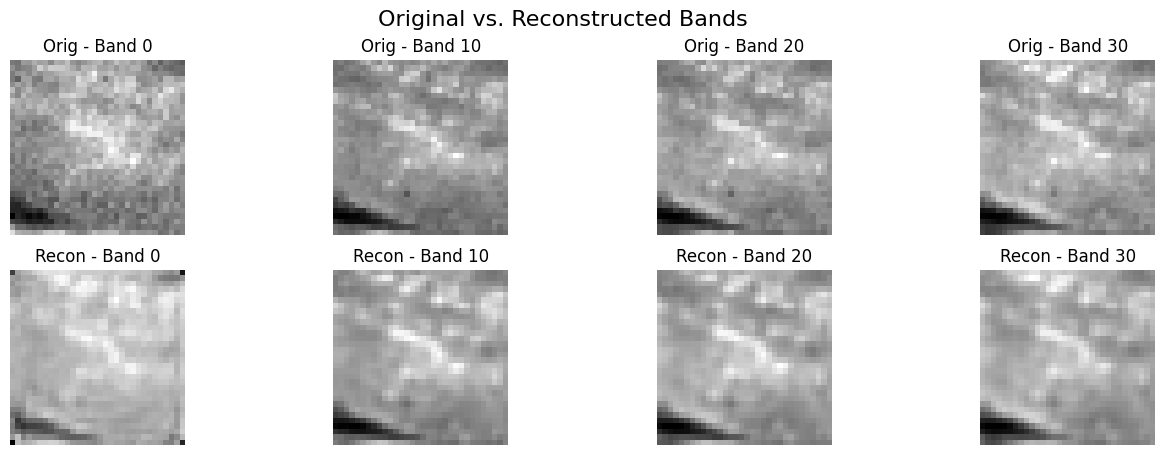

In [ ]:


# ===============================
# 9. Enhanced Visualization for Research Paper
# ===============================
model.eval()
with torch.no_grad():
    sample_idx = np.random.randint(0, len(dataset))
    sample = dataset[sample_idx].unsqueeze(0).to(device)
    output = model(sample).cpu().squeeze().permute(1, 2, 0).numpy()  # (patch_size, patch_size, 31)
    original = sample.cpu().squeeze().permute(1, 2, 0).numpy()

# -------- Display Multiple Bands --------
num_display_bands = len(Config.bands_to_plot)
plt.figure(figsize=(4 * num_display_bands, 5))
for i, band in enumerate(Config.bands_to_plot):
    plt.subplot(2, num_display_bands, i + 1)
    plt.imshow(original[..., band], cmap='gray')
    plt.title(f"Orig - Band {band}")
    plt.axis('off')

    plt.subplot(2, num_display_bands, num_display_bands + i + 1)
    plt.imshow(output[..., band], cmap='gray')
    plt.title(f"Recon - Band {band}")
    plt.axis('off')
plt.suptitle("Original vs. Reconstructed Bands", fontsize=16)
plt.show()






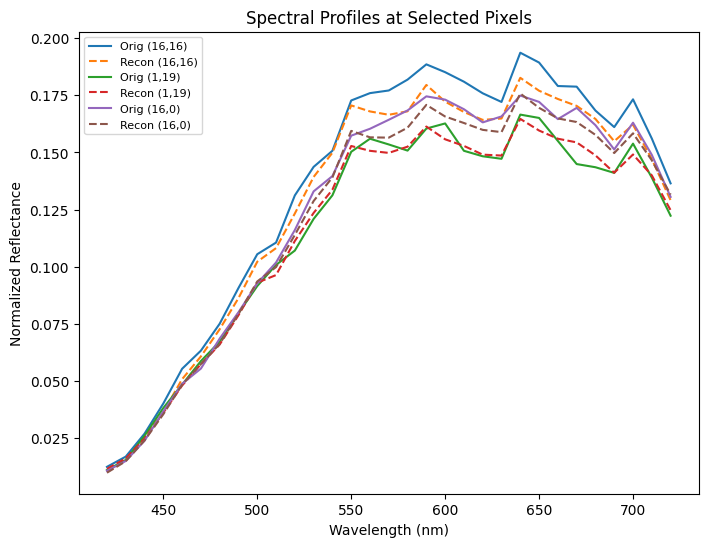

In [ ]:
# -------- Plot Spectral Profiles at Multiple Points --------
points = [(Config.patch_size // 2, Config.patch_size // 2)]
for _ in range(2):
    i = np.random.randint(0, Config.patch_size)
    j = np.random.randint(0, Config.patch_size)
    points.append((i, j))

plt.figure(figsize=(8,6))
for (i, j) in points:
    plt.plot(Config.wavelengths, original[i, j], label=f"Orig ({i},{j})", linestyle='-')
    plt.plot(Config.wavelengths, output[i, j], label=f"Recon ({i},{j})", linestyle='--')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalized Reflectance")
plt.title("Spectral Profiles at Selected Pixels")
plt.legend(loc='best', fontsize=8)
plt.show()

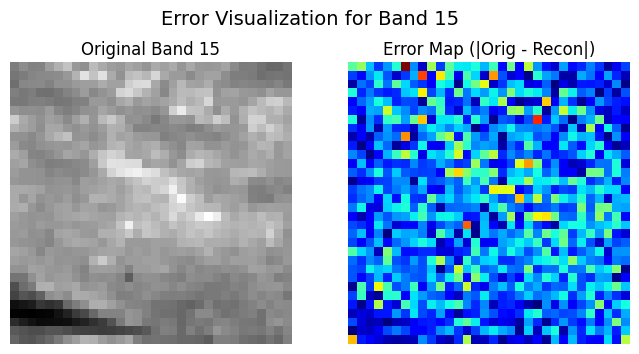

In [ ]:
# -------- Display Error Map for One Representative Band --------
band_choice = 15  # Example: use band 15
error_map = np.abs(original[..., band_choice] - output[..., band_choice])
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(original[..., band_choice], cmap='gray')
plt.title(f"Original Band {band_choice}")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(error_map, cmap='jet')
plt.title("Error Map (|Orig - Recon|)")
plt.axis('off')
plt.suptitle(f"Error Visualization for Band {band_choice}", fontsize=14)
plt.show()

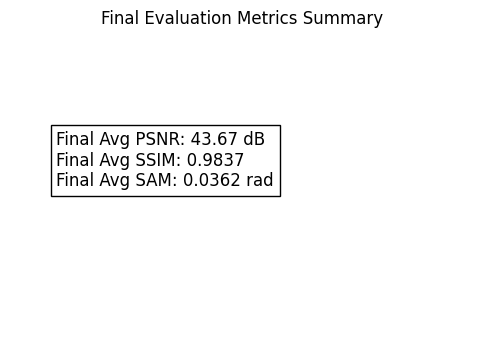

In [ ]:
# -------- Aggregate Metrics Visualization --------
plt.figure(figsize=(6,4))
text_str = f"Final Avg PSNR: {avg_psnr:.2f} dB\nFinal Avg SSIM: {avg_ssim:.4f}\nFinal Avg SAM: {avg_sam:.4f} rad"
plt.text(0.1, 0.5, text_str, fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))
plt.axis('off')
plt.title("Final Evaluation Metrics Summary")
plt.show()

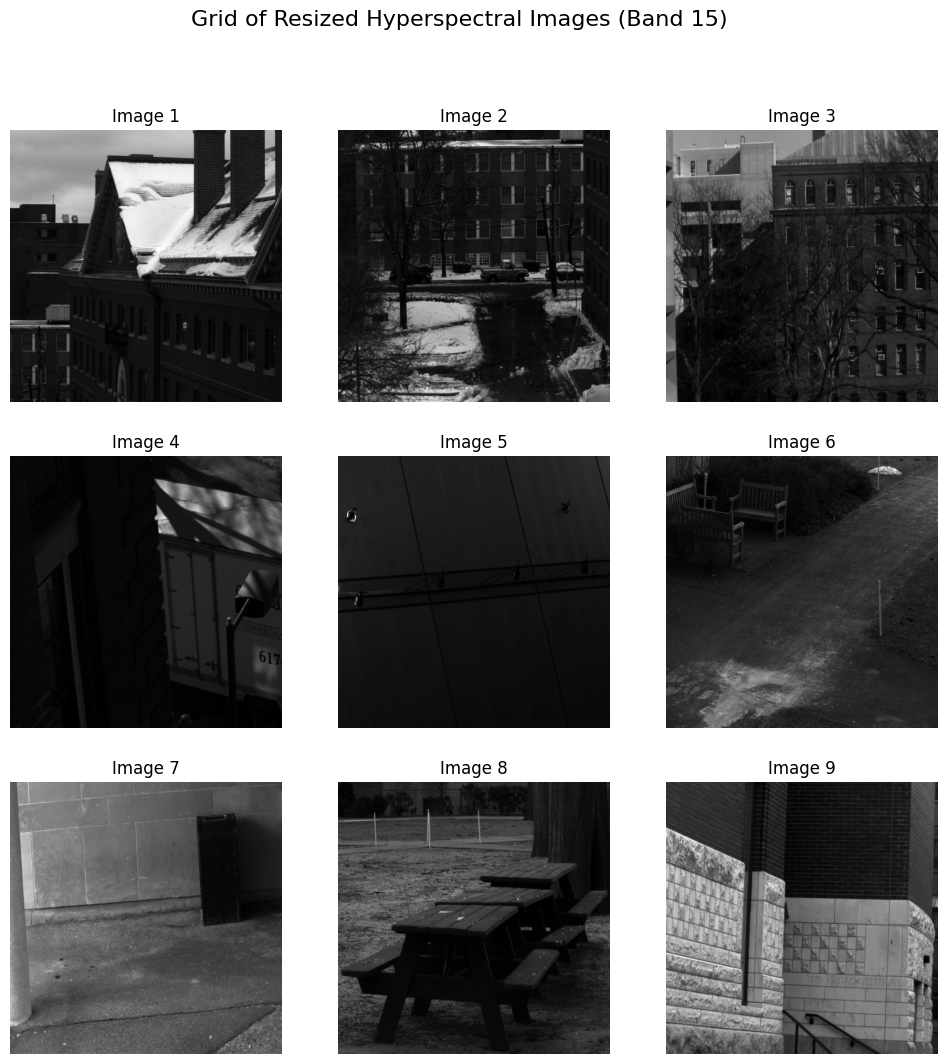

In [ ]:
# -------- Display a Grid of Some Resized Images --------
num_images_to_show = min(9, len(hs_images))
plt.figure(figsize=(12, 12))
for idx in range(num_images_to_show):
    plt.subplot(3, 3, idx+1)
    plt.imshow(hs_images[idx][..., 15], cmap='gray')
    plt.title(f"Image {idx+1}")
    plt.axis('off')
plt.suptitle("Grid of Resized Hyperspectral Images (Band 15)", fontsize=16)
plt.show()

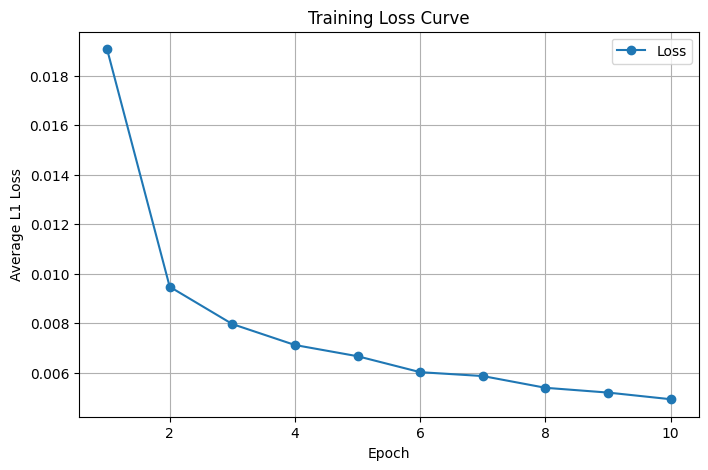

In [ ]:
# -------- Plot Training Loss Curve --------
plt.figure(figsize=(8,5))
plt.plot(range(1, Config.num_epochs+1), train_losses, marker='o', label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Average L1 Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.legend()
plt.show()

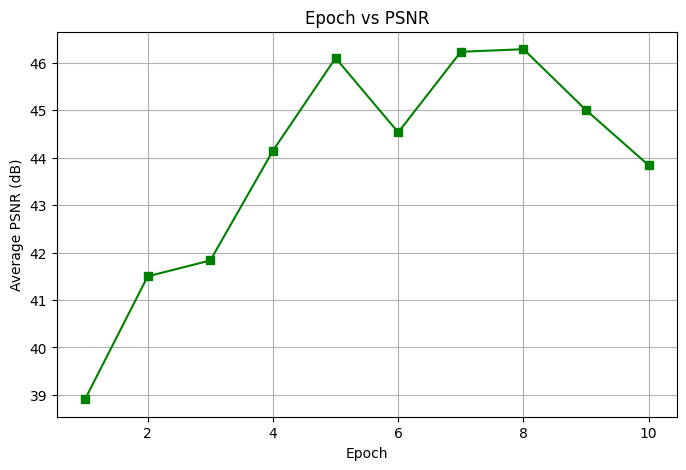

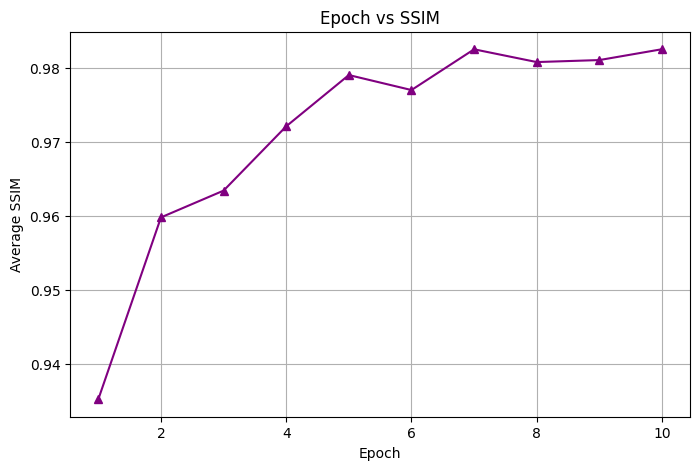

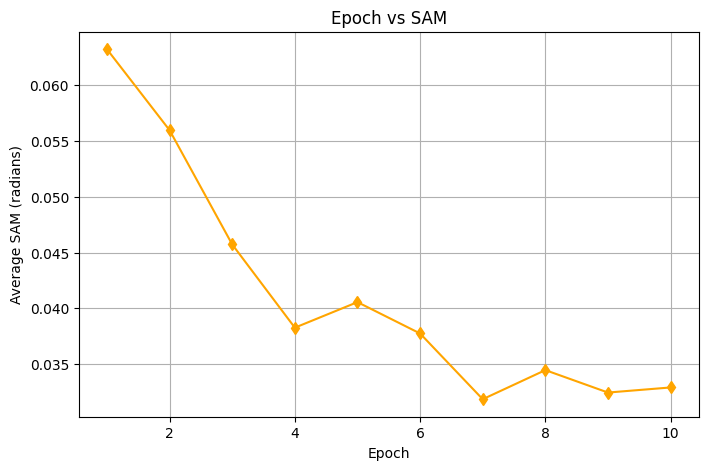

In [ ]:


# -------- Plot Epoch vs PSNR --------
plt.figure(figsize=(8,5))
plt.plot(range(1, Config.num_epochs+1), epoch_psnr, marker='s', color='green')
plt.xlabel("Epoch")
plt.ylabel("Average PSNR (dB)")
plt.title("Epoch vs PSNR")
plt.grid(True)
plt.show()

# -------- Plot Epoch vs SSIM --------
plt.figure(figsize=(8,5))
plt.plot(range(1, Config.num_epochs+1), epoch_ssim, marker='^', color='purple')
plt.xlabel("Epoch")
plt.ylabel("Average SSIM")
plt.title("Epoch vs SSIM")
plt.grid(True)
plt.show()

# -------- Plot Epoch vs SAM --------
plt.figure(figsize=(8,5))
plt.plot(range(1, Config.num_epochs+1), epoch_sam, marker='d', color='orange')
plt.xlabel("Epoch")
plt.ylabel("Average SAM (radians)")
plt.title("Epoch vs SAM")
plt.grid(True)
plt.show()


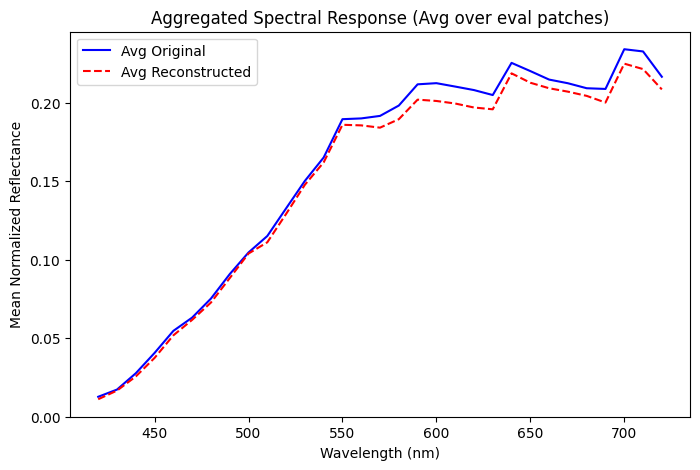

In [ ]:
# -------- Compute and Plot an Aggregated Spectral Response --------
all_orig_spectra = []
all_recon_spectra = []
for _ in range(Config.eval_sample_count):
    patch = dataset[np.random.randint(0, len(dataset))]
    patch_tensor = patch.unsqueeze(0).to(device)
    with torch.no_grad():
        recon = model(patch_tensor).cpu().squeeze().permute(1, 2, 0).numpy()
    orig = patch.cpu().permute(1, 2, 0).numpy()
    # Average the spectra over spatial dimensions
    all_orig_spectra.append(orig.mean(axis=(0,1)))
    all_recon_spectra.append(recon.mean(axis=(0,1)))
avg_orig_spectrum = np.mean(all_orig_spectra, axis=0)
avg_recon_spectrum = np.mean(all_recon_spectra, axis=0)

plt.figure(figsize=(8,5))
plt.plot(Config.wavelengths, avg_orig_spectrum, 'b-', label='Avg Original')
plt.plot(Config.wavelengths, avg_recon_spectrum, 'r--', label='Avg Reconstructed')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Mean Normalized Reflectance")
plt.title("Aggregated Spectral Response (Avg over eval patches)")
plt.legend(loc='best')
plt.show()